In [1]:
pip install surprise plotly -q


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

from surprise import accuracy, Dataset, SVD, Reader
from surprise.model_selection import train_test_split, KFold

In [3]:
#https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset/data
books_pd = pd.read_csv("dataIA/books/Ratings.csv")
books_user = pd.read_csv("dataIA/books/Users.csv")

books_pd.shape


(1149780, 3)

# Distribuição das avaliações notas

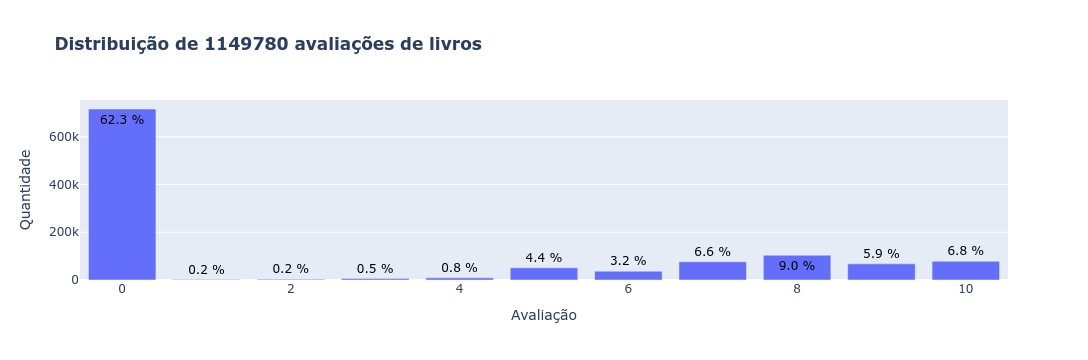

In [4]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data_plot = books_pd['Book-Rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data_plot.index,
               text = ['{:.1f} %'.format(val) for val in (data_plot.values / books_pd.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data_plot.values,
               )
# Create layout
layout = dict(title = '<b>Distribuição de {} avaliações de livros</b>'.format(books_pd.shape[0]),
              xaxis = dict(title = 'Avaliação'),
              yaxis = dict(title = 'Quantidade'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [5]:
data_plot.head()

10     78610
9      67541
8     103736
7      76457
6      36924
Name: Book-Rating, dtype: int64

# Distribuição das avaliações agrupadas por livro

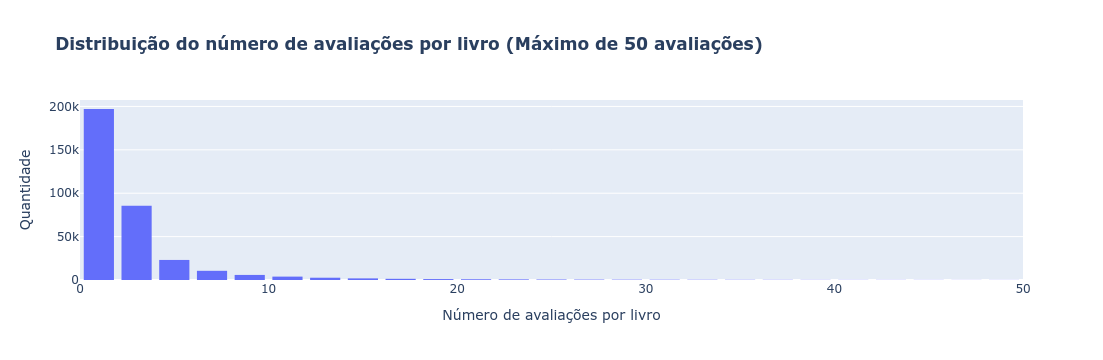

In [6]:
data_plot_by_book = books_pd.groupby('ISBN')['Book-Rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data_plot_by_book.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = '<b>Distribuição do número de avaliações por livro (Máximo de 50 avaliações)</b>',
                   xaxis = dict(title = 'Número de avaliações por livro'),
                   yaxis = dict(title = 'Quantidade'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

# Distribuição das avaliações agrupadas por usuários

In [7]:
books_pd.groupby('User-ID')['Book-Rating'].count().clip(upper=20)

User-ID
2          1
7          1
8         18
9          3
10         2
          ..
278846     2
278849     4
278851    20
278852     1
278854     8
Name: Book-Rating, Length: 105283, dtype: int64

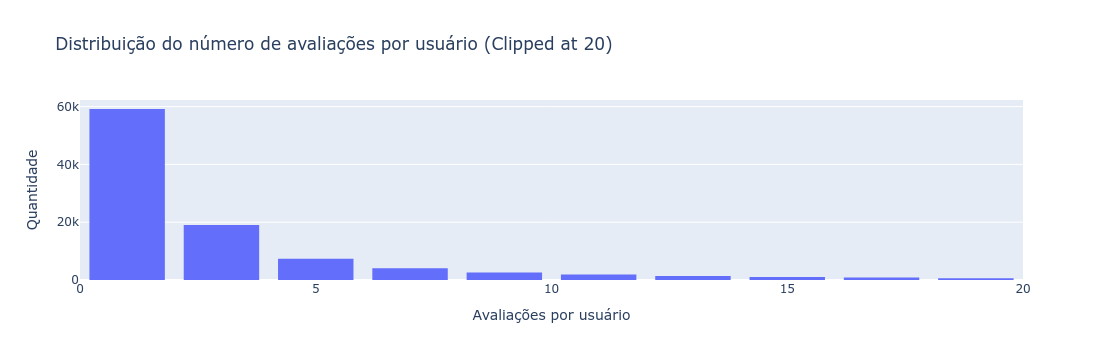

In [8]:
# Number of ratings per user
data_plot_by_user =books_pd.groupby('User-ID')['Book-Rating'].count().clip(upper=20)

# Create trace
trace = go.Histogram(x = data_plot_by_user.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 20,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribuição do número de avaliações por usuário (Clipped at 20)',
                   xaxis = dict(title = 'Avaliações por usuário'),
                   yaxis = dict(title = 'Quantidade'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

# EDA

In [9]:
df_filter = books_pd.groupby('User-ID')['Book-Rating'].count().reset_index().sort_values('Book-Rating', ascending=True)[:10]
df_filter = df_filter.rename(columns={"Book-Rating": "Quantidade Avaliações"})
df_filter

User-ID  Quantidade Avaliações
0            2                      1
60223   159665                      1
60222   159662                      1
60221   159655                      1
60220   159651                      1
60218   159648                      1
60216   159641                      1
60224   159666                      1
60214   159637                      1
60212   159633                      1

In [10]:
len(books_user)
books_user.head()

User-ID                            Location   Age
0        1                  nyc, new york, usa   NaN
1        2           stockton, california, usa  18.0
2        3     moscow, yukon territory, russia   NaN
3        4           porto, v.n.gaia, portugal  17.0
4        5  farnborough, hants, united kingdom   NaN

# Redução dimensionalidade

In [11]:
min_book_ratings = 50
filter_books = books_pd['ISBN'].value_counts() >= min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 5
filter_users = books_pd['User-ID'].value_counts() >= min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = books_pd[(books_pd['ISBN'].isin(filter_books)) & (books_pd['User-ID'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(books_pd.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(1149780, 3)
The new data frame shape:	(206272, 3)


In [12]:
df_new.head()

User-ID        ISBN  Book-Rating
10   276746  0425115801            0
11   276746  0449006522            0
12   276746  0553561618            0
13   276746  055356451X            0
16   276747  0060517794            9

# Define Reader e carrega Dataset

In [13]:
# A reader is still needed but only the rating_scale param is required.
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df_new[['User-ID', 'ISBN', 'Book-Rating']], reader)


# Exemplo predição de recomendações com SVD

In [14]:
trainset, testset = train_test_split(data, test_size=0.2)
from surprise import SVD
from collections import defaultdict

algoSVD = SVD()

def get_top(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n



In [15]:
algoSVD.fit(trainset)
predictions_svd = algoSVD.test(testset)

top_n = get_top(predictions_svd, n=5)


In [16]:
# retorna as recomendações (isbn e rating) para o usuário uuid: 189334
for user_ratings in top_n[189334]:
    print(user_ratings)

('0671004565', 3.6134043275909167)
('0375727345', 3.486287646765143)
('0316780375', 2.9165337250334527)
('0452269571', 2.7699695703319804)
('0380978415', 2.666497935202625)


In [17]:
accuracy.rmse(predictions_svd, verbose=True)
accuracy.mae(predictions_svd, verbose=True)
accuracy.fcp(predictions_svd, verbose=True)

df_svd = pd.DataFrame(predictions_svd,columns=['uid', 'iid', 'rui', 'est', 'details'])
df_svd['err'] = abs(df_svd.est - df_svd.rui)

df_svd.nlargest(3, 'err')


RMSE: 3.7021
MAE:  3.1470
FCP:  0.4834


uid         iid  rui   est                    details   err
955     6563  0316776963  0.0  10.0  {'was_impossible': False}  10.0
3488  163973  0553280341  0.0  10.0  {'was_impossible': False}  10.0
3740  258270  0345417623  0.0  10.0  {'was_impossible': False}  10.0

In [18]:

df_svd.nsmallest(3, 'err')


uid         iid   rui   est                    details  err
19    254206  0451163524  10.0  10.0  {'was_impossible': False}  0.0
1890  247583  0971880107   1.0   1.0  {'was_impossible': False}  0.0
1909  105221  0439139597  10.0  10.0  {'was_impossible': False}  0.0

# Comparativo de predição entre algoritmos diferentes

In [19]:
from surprise import KNNBasic, KNNBaseline

sim_options = {
    #"name": "cosine",
    "user_based": False,  # compute  similarities between items
    "min_support": 1
}

algo_knn = KNNBasic()
from time import time

kf = KFold(n_splits=5)
from time import time

data_plot = []
epoca = 0

for trainset_compare, testset_compare in kf.split(data):
    start_time = int(time() * 1000)
    algo_knn.fit(trainset_compare)
    end_time = int(time() * 1000)
    predictions_knn = algo_knn.test(testset_compare)
    mae_knn = accuracy.mae(predictions_knn, verbose=False)
    time_knn = end_time - start_time
    
    start_time = int(time() * 1000)
    algoSVD.fit(trainset_compare)
    end_time = int(time() * 1000)
    predictions_svd = algoSVD.test(testset_compare)
    mae_svd = accuracy.mae(predictions_svd, verbose=False)
    time_svd = end_time - start_time

    data_plot.append((epoca, "knn", mae_knn, time_knn))
    data_plot.append((epoca, "svd", mae_svd, time_svd))
    epoca = epoca +1
   



Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [20]:
columns = ["Epoca", "Algoritmo", "MAE", "TempoTreinamento"]
pd_acc = pd.DataFrame(data_plot, columns = columns)

pd_acc.head()

Epoca Algoritmo       MAE  TempoTreinamento
0      0       knn  3.235596              3359
1      0       svd  3.141444              1158
2      1       knn  3.251460              3344
3      1       svd  3.146513              1235
4      2       knn  3.240211              3384

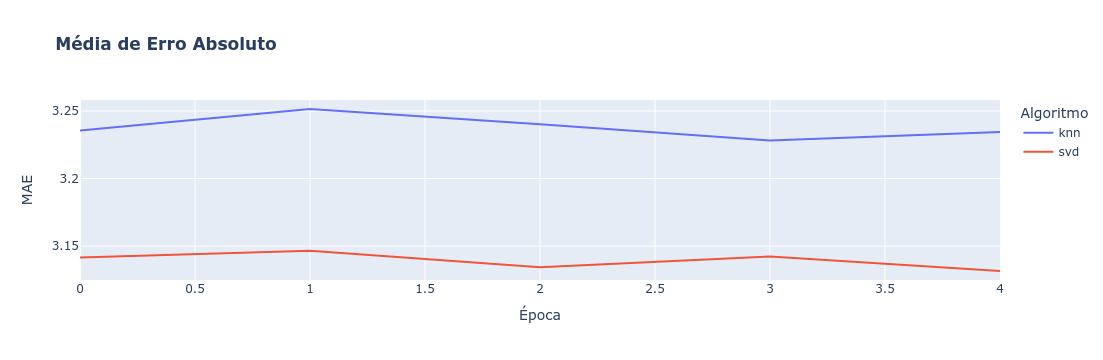

In [21]:
import plotly.express as px
figMae = px.line(pd_acc, x="Epoca", y="MAE", color="Algoritmo", title="<b>Média de Erro Absoluto</b>",labels={"Epoca": "Época"},)
figMae.show()

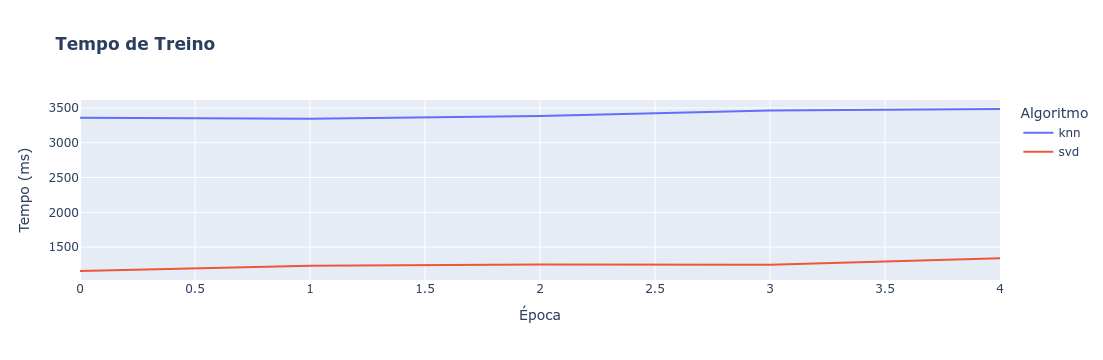

In [22]:

figTrainningTime = px.line(pd_acc, x="Epoca", y="TempoTreinamento", color='Algoritmo', title = "<b>Tempo de Treino</b>", 
                           labels={"Epoca": "Época", "TempoTreinamento": "Tempo (ms)"},)
figTrainningTime.show()

# Tunning

In [23]:
from surprise.model_selection import GridSearchCV
param_grid = {"n_epochs": [5, 10], "lr_all": [0.002, 0.005], "reg_all": [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=["mae"], cv=5)

gs.fit(data)
# best MAE score
print(gs.best_score["mae"])
# combination of parameters that gave the best MAE score
print(gs.best_params["mae"])

3.15753734252142
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [24]:

param_grid = {
    'k': [15, 25],
    'min_k':[1,5],
    'sim_options': {
        #'name': ['msd', 'cosine'],
        'min_support': [1, 5],
        'user_based': [False],
    },
}
gs = GridSearchCV(KNNBasic, param_grid, measures=["mae"], cv=5)

gs.fit(data)
# best MAE score
print(gs.best_score["mae"])
# combination of parameters that gave the best MAE score
print(gs.best_params["mae"])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi